In [32]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [33]:
base_image_path = "Toronto2.jpg"

In [34]:
b_img = Image.open(base_image_path)

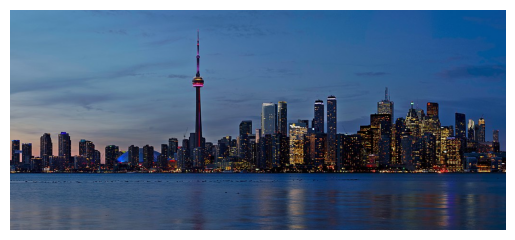

In [35]:
plt.imshow(b_img)
plt.axis("off");

In [36]:
style_image_path = "StarryNight.jpg"
style_img = Image.open(style_image_path)

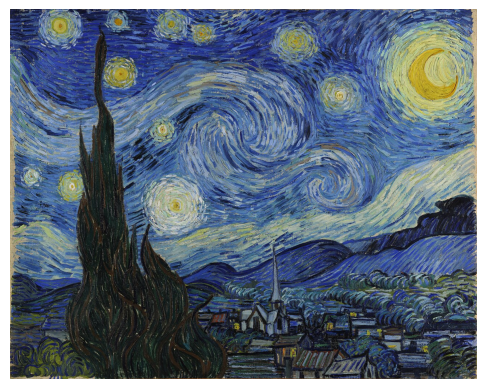

In [37]:
plt.imshow(style_img)
plt.axis("off");

In [38]:
# setting the dimensions og generated image:

In [39]:
org_width, org_heinght = keras.utils.load_img(base_image_path).size

In [40]:
org_width, org_heinght

(1040, 462)

In [41]:
img_height = 400
img_width = round(org_width * img_height / org_heinght)

In [42]:
img_width

900

In [43]:
import numpy as np

In [44]:
# preprocessig and potprocessing functions:

In [45]:
def preprocessing_img(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = keras.applications.vgg19.preprocess_input(img)

    return img


def deprocess_img(img):
    img = img.reshape((img_height,img_width,3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")

    return img

In [46]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
output_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=output_dict)

In [47]:
# content loss:

In [48]:
def content_loss(base_img, comb_img):
    return tf.reduce_sum(tf.square(comb_img - base_img))

In [49]:
# style loss:

In [50]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, comb_img):
    S = gram_matrix(style_img)
    C = gram_matrix(comb_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S-C) / (4.0 * (channels ** 2) * (size ** 2)))

In [51]:
# total variation loss:

In [52]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width -1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, img_height -1, : img_width -1, :] - x[:, : img_height -1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a+b, 1.25))

In [53]:
# Defining final loss to be minimized:

In [54]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
]

content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8


In [55]:
def compute_loss(comb_img, base_img, style_reference_image):
    input_tensor = tf.concat(
        [base_img, style_reference_image, comb_img], axis = 0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
            style_reference_features, combination_features
        )
        loss += (style_weight / len(style_layer_names)) * style_loss_value
    loss += total_variation_weight * total_variation_loss(comb_img)
    return loss

In [56]:
# Gradient descent process:

In [57]:
@tf.function
def compute_loss_and_grad(comb_img, base_img, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(
            comb_img, base_img, style_reference_image
        )
    grads = tape.gradient(loss, comb_img)
    return loss, grads

In [58]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

In [59]:
base_image = preprocessing_img(base_image_path)
style_reference_image = preprocessing_img(style_image_path)
combination_img = tf.Variable(preprocessing_img(base_image_path))

In [60]:
iterations = 4000

In [61]:
for i in range(1, iterations +1):
    loss, grads = compute_loss_and_grad(
        combination_img, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_img)])

    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_img(combination_img.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname,img)

Iteration 100: loss=13727.41
Iteration 200: loss=10286.39
Iteration 300: loss=8490.11
Iteration 400: loss=7369.55
Iteration 500: loss=6610.17
Iteration 600: loss=6068.42
Iteration 700: loss=5667.12
Iteration 800: loss=5360.49
Iteration 900: loss=5120.60
Iteration 1000: loss=4928.95
Iteration 1100: loss=4773.44
Iteration 1200: loss=4645.35
Iteration 1300: loss=4538.46
Iteration 1400: loss=4448.31
Iteration 1500: loss=4371.44
Iteration 1600: loss=4305.49
Iteration 1700: loss=4248.47
Iteration 1800: loss=4198.83
Iteration 1900: loss=4155.35
Iteration 2000: loss=4116.93
Iteration 2100: loss=4082.79
Iteration 2200: loss=4052.26
Iteration 2300: loss=4024.84
Iteration 2400: loss=4000.15
Iteration 2500: loss=3977.83
Iteration 2600: loss=3957.60
Iteration 2700: loss=3939.13
Iteration 2800: loss=3922.24
Iteration 2900: loss=3906.73
Iteration 3000: loss=3892.46
Iteration 3100: loss=3879.29
Iteration 3200: loss=3867.10
Iteration 3300: loss=3855.84
Iteration 3400: loss=3845.39
Iteration 3500: loss=